# ResNet 구현

In [20]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as T
import torchvision.utils as vutils

from torchsummary import summary

### Inception Module

In [38]:
# https://github.com/soapisnotfat/pytorch-cifar10/blob/master/models/GoogleNet.py

class Inception(torch.nn.Module):
    def __init__(self, in_channels, kernel_1_x, kernel_3_in, kernel_3_x, kernel_5_in, kernel_5_x, pool_channels):
        super(Inception, self).__init__()
        # 1x1 conv
        self.branch1 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels, kernel_1_x, kernel_size=1), # 1x1 conv
            torch.nn.BatchNorm2d(kernel_1_x),
            torch.nn.ReLU(True),
        )

        # 1x1 conv -> 3x3 conv branch
        self.branch2 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels, kernel_3_in, kernel_size=1), # 1x1 conv
            torch.nn.BatchNorm2d(kernel_3_in),
            torch.nn.ReLU(inplace = True),
            torch.nn.Conv2d(kernel_3_in, kernel_3_x, kernel_size=3, padding=1), # 3x3 conv
            torch.nn.BatchNorm2d(kernel_3_x),
            torch.nn.ReLU(inplace = True),
        )

        # 1x1 conv -> 5x5 conv branch
        self.branch3 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels, kernel_5_in, kernel_size=1), # 1x1 conv
            torch.nn.BatchNorm2d(kernel_5_in),
            torch.nn.ReLU(True),
            torch.nn.Conv2d(kernel_5_in, kernel_5_x, kernel_size=5, padding=2), # 5x5 conv
            torch.nn.BatchNorm2d(kernel_5_x),
            torch.nn.ReLU(True),
        )

        # 3x3 pool -> 1x1 conv branch
        self.branch4 = torch.nn.Sequential(
            torch.nn.MaxPool2d(3, stride=1, padding=1), # 3x3 max pooling
            torch.nn.Conv2d(in_channels, pool_channels, kernel_size=1), # 1x1 conv
            torch.nn.BatchNorm2d(pool_channels),
            torch.nn.ReLU(True),
        )

    def forward(self, x):
        '''
        INPUT :
            x = [batch_size, channel, height, width]
        OUTPUT :
            output = [batch_size, num_classes]
        '''
        y1 = self.branch1(x) # [batch_size, kernel_1_x, height, width]
        y2 = self.branch2(x) # [batch_size, kernel_3_x, height, width]
        y3 = self.branch3(x) # [batch_size, kernel_5_x, height, width]
        y4 = self.branch4(x) # [batch_size, pool_channels, height, width]
        # 병렬로 계산된 convolution 들을 모두 합쳐줍니다.
        return torch.cat([y1,y2,y3,y4], 1)  # [batch_size, kernel_1_x + kerenl_3_x + kernel_5_x + pool_channels, height, width]

### GoogLeNet

In [39]:
class GoogLeNet(torch.nn.Module): # googlenet 논문의 구조를 그대로 반영하였습니다.
    def __init__(self, num_classes, aux_logits = True):
        super(GoogLeNet, self).__init__()

        self.num_classes = num_classes
        self.aux_logits = aux_logits

        self.pre_layers = torch.nn.Sequential(
            torch.nn.Conv2d(3, 192, kernel_size=3, padding=1),
            torch.nn.BatchNorm2d(192),
            torch.nn.ReLU(True),
        )

        self.inception_1 = Inception(192,  64,  96, 128, 16, 32, 32) # inception 1, inception 2 이런 식으로 변수 이름 변경
        self.inception_2 = Inception(256, 128, 128, 192, 32, 96, 64)

        self.max_pool = torch.nn.MaxPool2d(3, stride=2, padding=1)

        self.inception_3 = Inception(480, 192,  96, 208, 16,  48,  64)
        self.inception_4 = Inception(512, 160, 112, 224, 24,  64,  64)
        self.inception_5 = Inception(512, 128, 128, 256, 24,  64,  64)
        self.inception_6 = Inception(512, 112, 144, 288, 32,  64,  64)
        self.inception_7 = Inception(528, 256, 160, 320, 32, 128, 128)

        self.inception_8 = Inception(832, 256, 160, 320, 32, 128, 128)
        self.inception_9 = Inception(832, 384, 192, 384, 48, 128, 128)


        self.avgpool = torch.nn.AvgPool2d(8, stride=1)
        self.linear = torch.nn.Linear(1024, self.num_classes)
        self.softmax = torch.nn.LogSoftmax(dim = 1)

    def forward(self, x):
        '''
        INPUT :
            x = [batch_size, channel, height, width]
        OUTPUT :
            output = [batch_size, num_classes]
        '''
        x = self.pre_layers(x) # [batch_size, 192, height, width]
        x = self.inception_1(x) # [batch_size, 256, height, width]
        x = self.inception_2(x) # [batch_size, 480, height, width]
        x = self.max_pool(x) # [batch_size, 480, height//2, width//2]
        x = self.inception_3(x) # [batch_size, 512, height//2, width//2]
        x = self.inception_4(x) # [batch_size, 512, height//2, width//2]
        x = self.inception_5(x) # [batch_size, 512, height//2, width//2]
        x = self.inception_6(x) # [batch_size, 528, height//2, width//2]
        x = self.inception_7(x) # [batch_size, 832, height//2, width//2]
        x = self.max_pool(x) # [batch_size, 832, height//4, width//4]
        x = self.inception_8(x) # [batch_size, 832, height//4, width//4]
        x = self.inception_9(x) # [batch_size, 832, height//4, width//4]
        x = self.avgpool(x) # [batch_size, 1024, height//4, width//4]
        x = x.view(x.size(0), -1) # [batch_size, 1024, 1, 1]
        x = self.linear(x) # [batch_size, num_classes]
        x = self.softmax(x) # [batch_size, num_classes]
        return x

    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

In [40]:
num_classes = 10
model = GoogLeNet(num_classes=num_classes)
model.count_parameters()

5879066

### train, eval 함수 정의

In [33]:
# 학습
def training(model, train_dataloader, train_dataset, criterion, optimizer):
    model.train() # 모델을 학습 상태로 변경
    train_loss = 0.0
    train_accuracy = 0

    tbar = tqdm(train_dataloader)
    for images, labels in tbar:
        # forward
        outputs = model(images)
        loss = criterion(outputs, labels)

        # vackward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() # loss함수를 사용하여 loss를 구한다.
        max_prob, predicted = torch.max(outputs, 1)
        train_accuracy += (predicted == labels).sum().item() # 예측과 실제를 비교해서 일치하는 것의 개수를 구한다.
    
    train_loss = train_loss / len(train_dataloader)
    train_accuracy = train_accuracy / len(train_dataset)

    return model, train_loss, train_accuracy

# 검증
def evaluation(model, valid_dataloader, valid_dataset, criterion):
    model.eval() # model을 평가 상태로 변경
    valid_loss = 0.0
    valid_accuracy = 0

    tbar = tqdm(valid_dataloader)
    for images, labels in tbar:
        outputs = model(images)
        loss = criterion(outputs, labels)

        valid_loss += loss.item()
        max_prob, predicted = torch.max(outputs, 1)        
        valid_accuracy += (predicted == labels).sum().item()

    valid_loss = valid_loss / len(valid_dataloader)
    valid_accuracy = valid_accuracy / len(valid_dataset)

    return model, valid_loss, valid_accuracy

# num_epochs만큼 학습 수행
def training_loop(model, train_dataloader, valid_dataloader, train_dataset, valid_dataset, criterion, optimizer, num_epochs):
    for epoch in range(num_epochs):
        print(epoch)
        model, trian_loss, train_accuracy = training(model, train_dataloader, train_dataset, criterion, optimizer)
        model, valid_loss, valid_accuracy = evaluation(model, valid_dataloader, valid_dataset, criterion)

        print(f'Train Loss: {trian_loss}, Train Accuracy: {train_accuracy}')
        print(f'Valid Loss: {valid_loss}, Valid Accuracy: {valid_accuracy}')

### dataload
- CIFAR사용

In [6]:
cifar10_transform = T.Compose([
    T.ToTensor()
])

In [10]:
download_root = './CIFAR10_DATASET'

train_dataset = torchvision.datasets.CIFAR10(download_root, transform=cifar10_transform, train=True, download=True)
test_dataset = torchvision.datasets.CIFAR10(download_root, transform=cifar10_transform, train=False, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [11]:
# train, valid 분할
import torch.utils


total_size = len(train_dataset)
train_num, valid_num = int(total_size * 0.8), int(total_size * 0.2)
print("Train dataset 개수 : ", train_num)
print("Validation dataset 개수 : ", valid_num)
print("Test dataset 개수 :", len(test_dataset))
train_dataset, valid_dataset = torch.utils.data.random_split(train_dataset, [train_num, valid_num])

Train dataset 개수 :  40000
Validation dataset 개수 :  10000
Test dataset 개수 : 10000


In [12]:
batch_size = 32

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [19]:
for images, labels in train_dataloader:
    print(f'batch_size: {len(images)}')
    print(f'image_shape: {images.shape}')
    print(labels)
    break

batch_size: 32
image_shape: torch.Size([32, 3, 32, 32])
tensor([8, 6, 3, 0, 1, 9, 8, 8, 5, 6, 4, 7, 9, 6, 3, 4, 5, 0, 5, 0, 6, 2, 2, 0,
        1, 0, 0, 4, 1, 7, 9, 5])


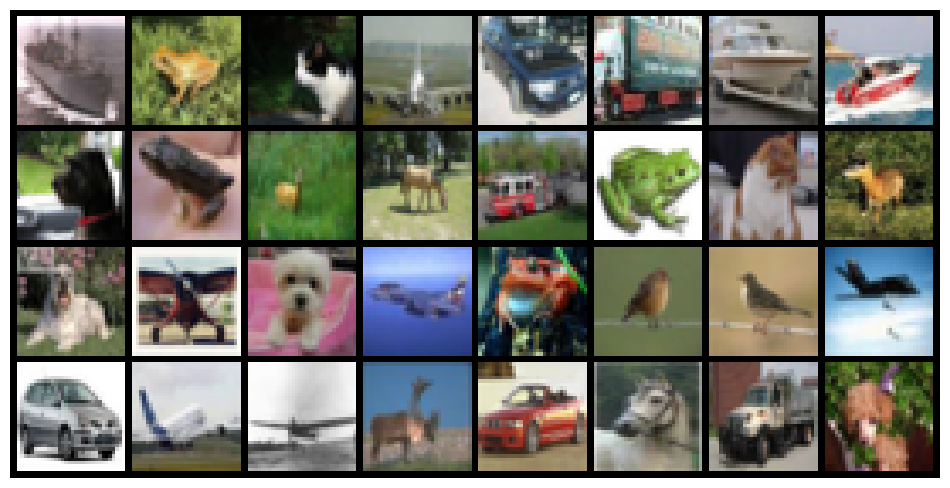

In [25]:
grid = vutils.make_grid(images, nrow=8)

plt.figure(figsize=(12, 12))
plt.imshow(grid.numpy().transpose((1, 2, 0)))
plt.axis('off')
plt.show()

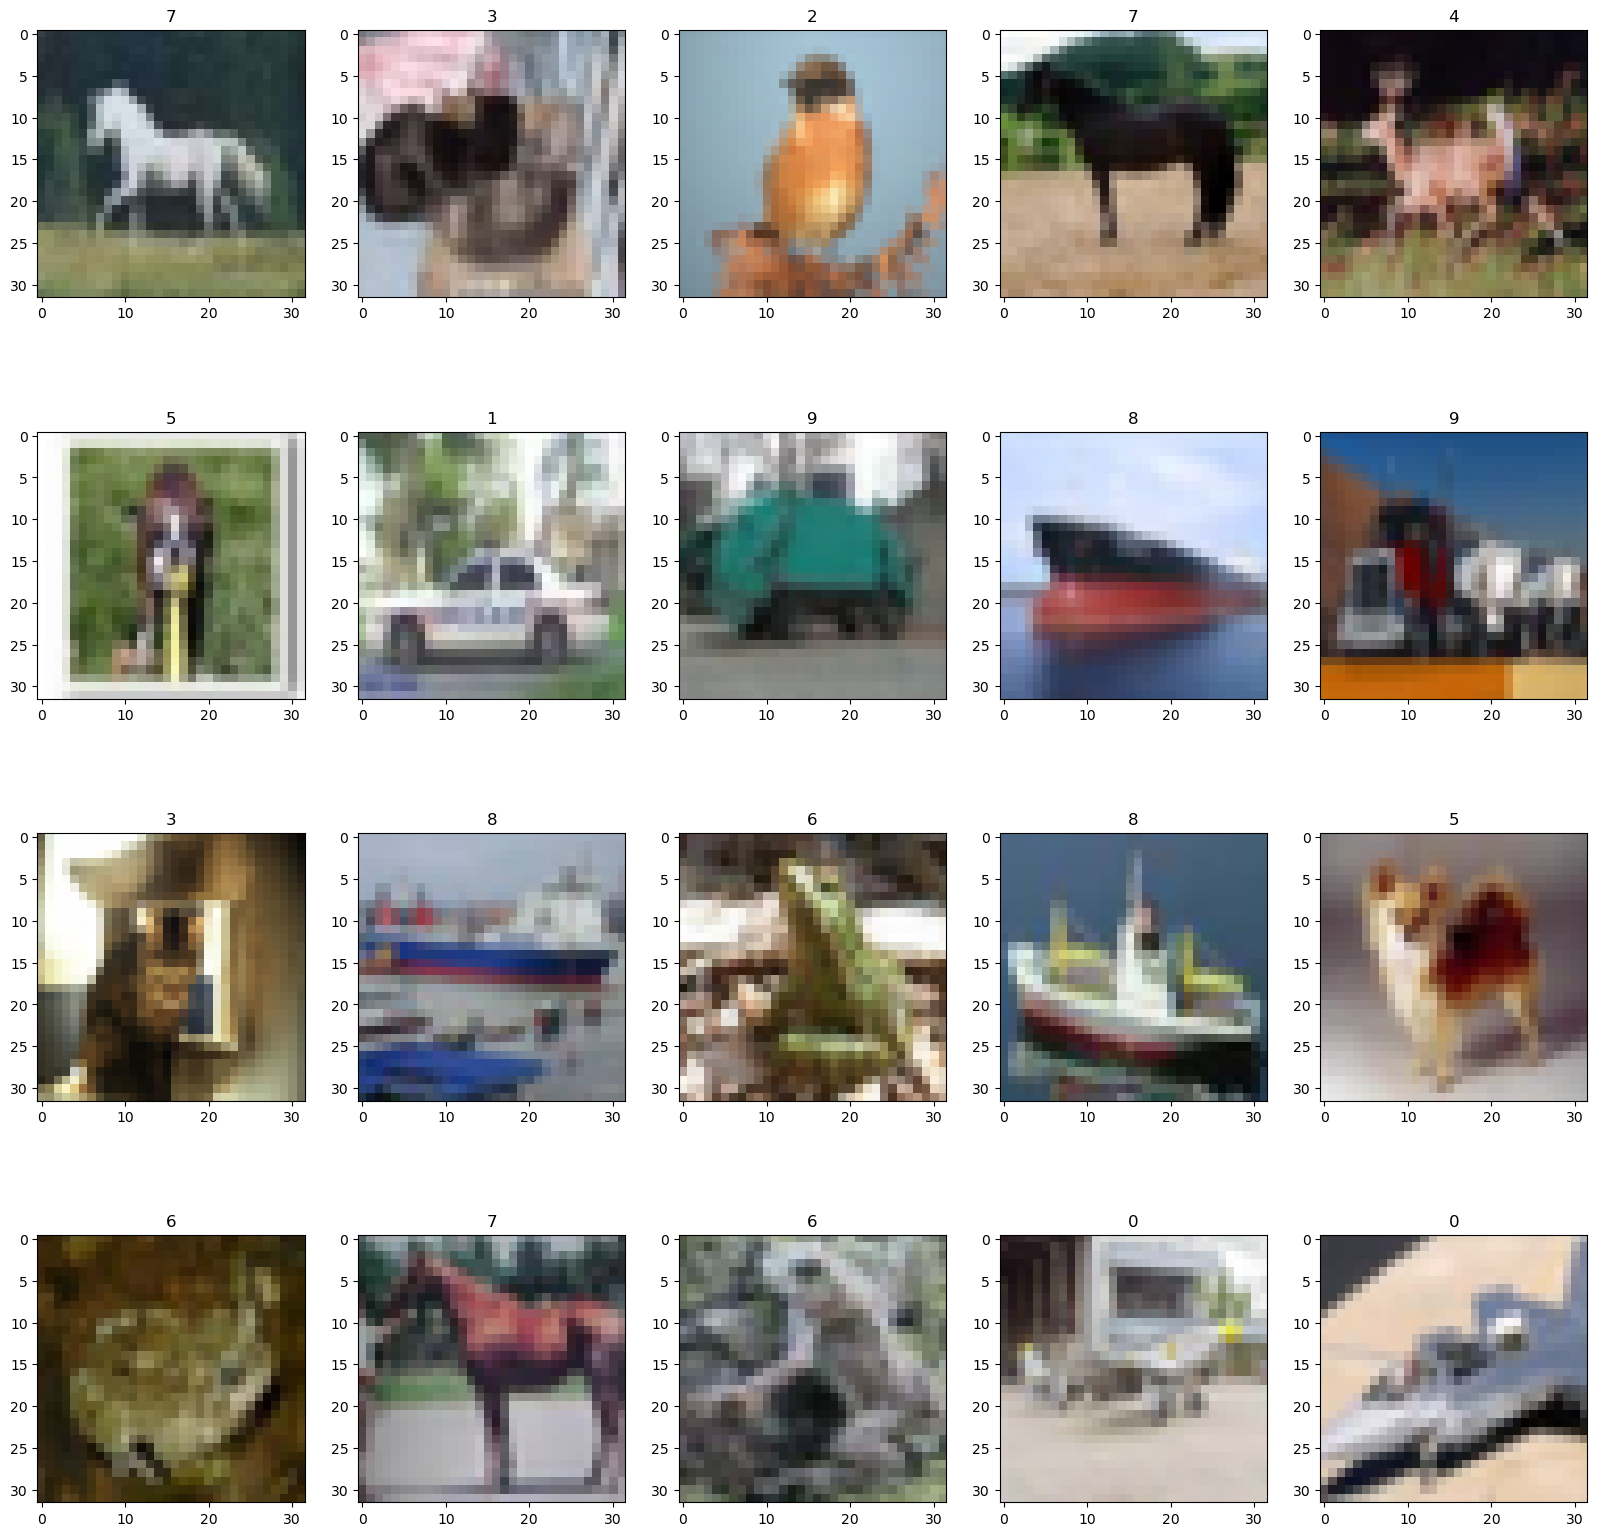

In [30]:
plt.figure(figsize=(20, 20))

for i in range(20):
    image_tmp = train_dataset[i][0].squeeze().numpy()
    # torch는 (channel, height, widht) -> plt.imshow()를 위해 (height, widht, channel)으로 변환
    image = np.transpose(image_tmp, (1, 2, 0))
    label = train_dataset[i][1]
    
    ax = plt.subplot(4, 5, i+1)
    plt.imshow(image)
    plt.title(label)

### model 학습

In [41]:
model = GoogLeNet(10)

criterion = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model = training_loop(model, train_dataloader, valid_dataloader, train_dataset, valid_dataset, criterion, optimizer, 5)

0


  0%|          | 0/1250 [00:00<?, ?it/s]

KeyboardInterrupt: 

### test

In [ ]:
def test(model, test_dataloader, test_dataset, criterion):
    model.eval()
    test_loss = 0.0
    test_accuracy = 0

    tbar = tqdm(test_dataloader)
    for images, labels in tbar:
        outputs = model(image)
        loss = criterion(outputs, labels)

        test_loss += loss.item()
        max_prob, predicted = torch.max(outputs, 1)
        test_accuracy += (predicted == labels).sum().item()
        
    test_loss = test_loss/len(test_dataloader)
    test_accuracy = test_accuracy/len(test_dataset)

    return test_loss, test_accuracy

In [ ]:
test_loss, test_accuracy = test(model, test_dataloader, test_dataset, criterion)